In [1]:
using Pkg
#Pkg.activate("NB04")
Pkg.add("StatsBase")
Pkg.add("Plots")
Pkg.add("LinearAlgebra")
Pkg.add("Optim")
Pkg.add("RDatasets")
Pkg.add("CSV")
Pkg.resolve();

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
   Installed LineSearches ── v7.2.0
   Installed NLSolversBase ─ v7.8.3
   Installed Optim ───────── v1.7.4
    Updating `~/.julia/environments/v1.8/Project.toml`
  [429524aa] + Optim v1.7.4
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [d3d80556] + LineSearches v7.2.0
  [d41bc354] + NLSolversBase v7.8.3
  [429524aa] + Optim v1.7.4
  [85a6dd25] + PositiveFactorizations v0.2.4
Precompiling project...
  ✓ NLSolversBase
  ✓ LineSearches
  ✓ Opt

In [3]:
using LinearAlgebra, Plots, StatsBase
using RDatasets
using Optim

# Regression

We load the data set `cars` from the package `RDatasets`

In [4]:
data_cars = dataset("datasets", "cars");

We first look at which variables are preserved in this dataset

In [5]:
names(data_cars)

2-element Vector{String}:
 "Speed"
 "Dist"

In [6]:
size(data_cars,1)

50

The data points represent speed and distance traveled.

We expect a linear relationship, so we choose the linear model

$$f_\theta(x) =  a x + b$$

with $\theta =(a,b)\in\mathbb R^2$.

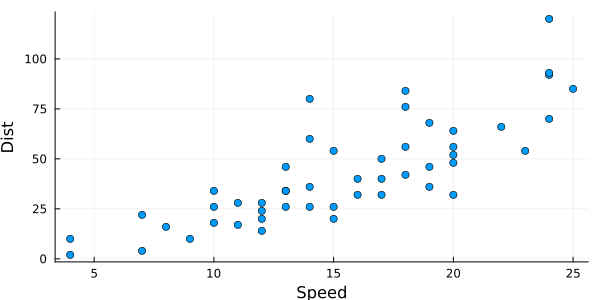

In [7]:
scatter(data_cars[:,"Speed"], data_cars[:,"Dist"], 
            legend=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))

We want to estimate the linear dependence of these variables using regression.

Both variables are one-dimensional. i.e.

In [8]:
D = 1; N = 1;

## Splitting the Data

We split the data into training and testing data.

The choice should be random and $75\%$ of the data should be training data.

In [9]:
k = size(data_cars, 1)
n = round(Int, k * 0.75)

38

We store the training data in the vectors `X` und `Y`.

In [10]:
i_training = sample(1:k, n, replace = false)
X = data_cars[i_training,"Speed"]
Y = data_cars[i_training,"Dist"];

We store the test data in the vectors `X_test` and `Y_test`.

In [11]:
i_test = setdiff(1:k, i_training)
X_test = data_cars[i_test,"Speed"]
Y_test = data_cars[i_test,"Dist"];

## Definition of the Model

We now define the deterministic linear model $f:\mathbb R^D \to \mathbb R^N$:

In [12]:
f(x::Number, θ) = θ[2] * x + θ[1];

Since $N=1$ we can specify the type `Number` for `x`.

It will also be helpful later to use multiple dispatch to extend the definition of `f` to include vectors.

In [13]:
f(X::Vector, θ) = [f(x, θ) for x in X]

f (generic function with 2 methods)

We continue to define the statistical model for the variance $\sigma^2=10$.

In [14]:
σ² = 10
s = sqrt(σ²)
Φ(x::Number, θ) = s * randn() + f(x, θ)
Φ(X::Vector, θ) = [Φ(x, θ) for x in X];

We also define the feature matrix.

In [15]:
Ω = [ones(n) X];

---
## Training

Now we train our model using different methods.

#### Empirical Risk Minimization

With ERM, the parameter is given by $\theta = \Omega^\dagger Y$.

We calculate this parameter as follows:

In [16]:
θ_ERM = Ω \ Y

2-element Vector{Float64}:
 -19.676355902162346
   4.105472691080628

ERM estimated the following parameters for $f_\theta(x)=ax+b$.

In [17]:
println("a = $(θ_ERM[2]), b = $(θ_ERM[1])")

a = 4.105472691080628, b = -19.676355902162346


We visualize the estimated function along with the training data.

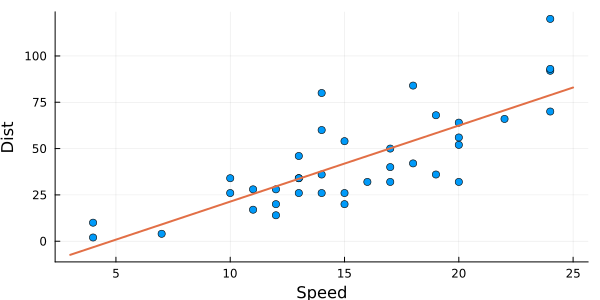

In [18]:
p = collect((minimum(X)-1):0.5:(maximum(X)+1))

scatter(X,Y, legend=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
plot!(p, f(p, θ_ERM), lw = 2)

### Ridge Regression

The ridge regression estimator with parameter $\lambda$ is calculated as follows.

In [19]:
θ_T(λ) = (Ω' * Ω + (n*λ) .* diagm(ones(D+1))) \ (Ω' * Y)

θ_T (generic function with 1 method)

We plot the RR estimator for different values of $\lambda$

┌ Info: Saved animation to 
│   fn = /Users/sfairchild/Documents/GitHub/MathData-Winter22-23/Notebooks/ridge_regression.gif
└ @ Plots /Users/sfairchild/.julia/packages/Plots/4UTBj/src/animation.jl:154


Plots.AnimatedGif("/Users/sfairchild/Documents/GitHub/MathData-Winter22-23/Notebooks/ridge_regression.gif")
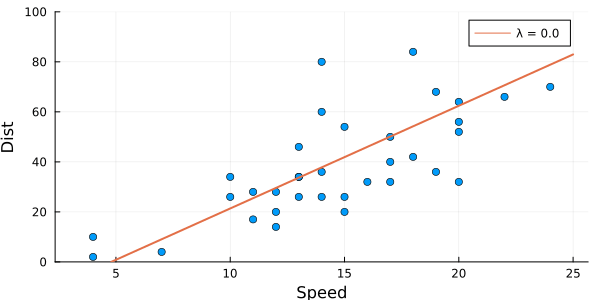

In [21]:
anim = @animate for λ in 0:0.02:0.25
    scatter(X,Y, label=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
    plot!(p, f(p, θ_T(λ)), lw = 2, label = "λ = $λ")
    ylims!(0,100)
end
gif(anim, "ridge_regression.gif", fps = 3)

Judging by the animation, $\lambda=0.2$ seems like a good choice.

In [22]:
θ_RR = θ_T(0.2);

RR estimated the following parameters for $f_\theta(x)=ax+b$.

In [23]:
println("a = $(θ_RR[2]), b = $(θ_RR[1])")

a = 3.317311937429321, b = -6.285690425354228


### Maximum Likelihood und Maximum a-Posteriori Estimation

The parameter for ML is determined by `θ_ERM`

The parameter for MAP is determined by `θ_T(λ)` for $\lambda = \sigma^2/n$.

In [24]:
θ_ML = θ_ERM
θ_MAP = θ_T(σ²/n);

Now we can insert these parameters into the statistical model and sample from it.

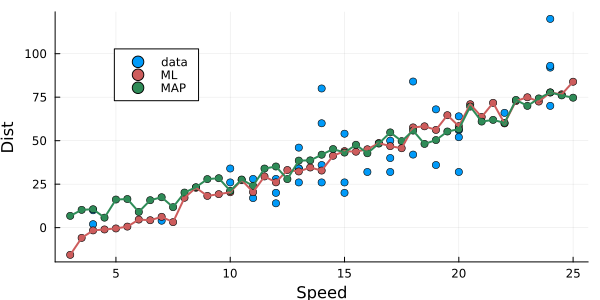

In [25]:
a1 = Φ(p, θ_ML)
a2 =  Φ(p, θ_MAP)
scatter(X,Y, label = "data", legend = (0.2,0.8),
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
scatter!(p, a1, lw = 2, c = :indianred, label ="ML")
scatter!(p, a2, lw = 2, c = :seagreen, label = "MAP")
plot!(p, a1, lw = 2, c = :indianred, label = false)
plot!(p, a2, lw = 2, c = :seagreen, label = false)

### Neural Network

Finally, we want to determine the dependency of `Dist` and `Speed` using a neural network.

We use the ReLu Activation Function.

In [26]:
σ(z) = max(0,z);

We define the model by a depth 2 neural network with inner layers given by linear functions $\mathbb R^1\to \mathbb R^2$ and $\mathbb R^2\to \mathbb R^1$.

This is a very simple neural network, but is therefore well suited to illustrate how it works.

In [27]:
function f_NN(x::Number, θ)
    A, b = reshape(θ[1:2], 2, 1), θ[3:4]
    y = σ.(A * x + b)
    
    A, b = reshape(θ[5:6], 1, 2), θ[7:7]
    z = σ.(A * y + b)
    
    z[1]
end
f_NN(X::Vector, θ) = [f_NN(x, θ) for x in X];

Since we don't have a closed form for the ERM estimator `θ_ERM` for the neural network, we have to determine `θ_ERM` by optimization methods.

We will use the black box `optimize` function from the `Optim.jl` package.

In [28]:
R_NN(θ, X, Y) = mean((f_NN(X, θ) - Y).^2)
o = optimize(θ -> R_NN(θ, X, Y), rand(7))
θ_NN = Optim.minimizer(o);

The neural network has now estimated a function, which we visualize again along with the training data.

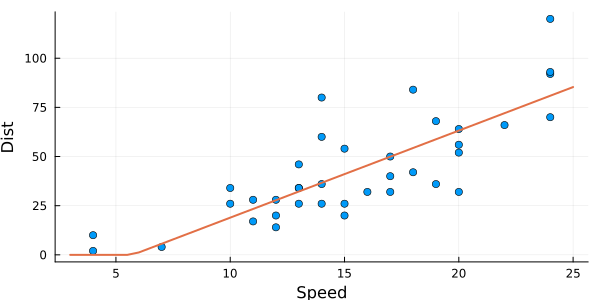

In [29]:
scatter(X,Y, legend=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
plot!(p, f_NN(p, θ_NN), lw = 2)

## Model Selection

Finally, we want to assess which model is best suited to describe the data. To do this, we evaluate the estimators on the test data.

First we plot all the estimated functions along with the test data.

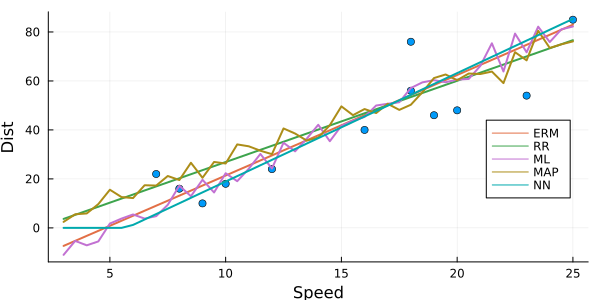

In [30]:
scatter(X_test,Y_test, legend=1,
            label = false,
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
plot!(p, f(p, θ_ERM), lw = 2, label = "ERM")
plot!(p, f(p, θ_RR), lw = 2, label = "RR")
plot!(p, Φ(p, θ_ML), lw = 2, label = "ML")
plot!(p, Φ(p, θ_MAP), lw = 2, label = "MAP")
plot!(p, f_NN(p, θ_NN), lw = 2, label = "NN")

To assess which model works how well, we define empirical risk.

In [31]:
R(θ, f, X, Y) = mean((f(X, θ) - Y).^2)

R (generic function with 1 method)

The empirical risk for training and test data in the deterministic linear model is as follows.

In [33]:
r = [(R(θ, f, X_test, Y_test), R(θ, f, X, Y)) for θ in [θ_ERM, θ_RR]]   
println("tisk test data ERM: $(r[1][1])\n")
println("tisk training data ERM: $(r[1][2])\n")
println("ERM risk ratio: $(r[1][1]/r[1][2])\n")
println("risk test data RR: $(r[2][1])\n")
println("risk training data RR: $(r[2][2])\n")
println("RR risk ratio: $(r[2][1]/r[2][2])\n")

tisk test data ERM: 131.62685183192528

tisk training data ERM: 258.71470334549866

ERM risk ratio: 0.5087722117445531

risk test data RR: 128.91003849078263

risk training data RR: 276.07153391617777

RR risk ratio: 0.4669443338186506



The following values result for the neural network.

In [34]:
r = (R(θ_NN, f_NN, X_test, Y_test), R(θ_NN, f_NN, X, Y))
println("risk test data NN: $(r[1])\n")
println("risk Training data NN: $(r[2])\n")
println("NN risk ratio: $(r[1]/r[2])\n")

risk test data NN: 144.97669177162135

risk Training data NN: 253.96386776202598

NN risk ratio: 0.5708555829188668



---
# Regularization

In the example above, we don't see much of a difference between ERM and RR.

Here is an example where regularization is important.

To do this, we generate $n=20$ synthetic data from a cubic polynomial plus noise:

In [104]:
q = (x -> 1 + 4*x + 2*x^2 - 0.5*x^3)

n = 20
P = 4
X = 10 .* (rand(n) .- 0.5); # randn sampled von Unif([-5,5])
Y = map(q, X) + 2 .* randn(n);

We plot the data

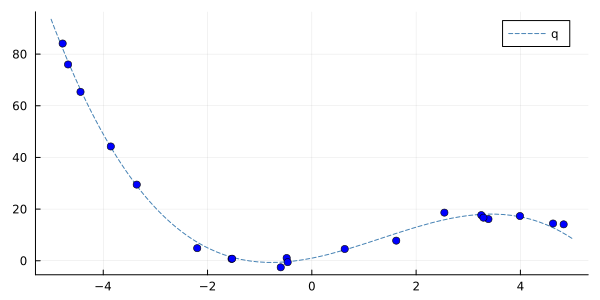

In [105]:
plot(q, label = "q", size = (600,300), linestyle = :dash, color = :steelblue)
scatter!(X,Y, label=false, color = :blue)

We calculate feature matrix and RR parameters.

In [106]:
Ω = hcat([X.^i for i in 0:P-1]...)
θ_T(λ) = (Ω' * Ω + (n*λ) .* diagm(ones(P))) \ (Ω' * Y)

θ_T (generic function with 1 method)

For each value of $\lambda$ we then get a polynomial like this:'

In [107]:
Q(λ) = (x -> sum(θ * x^(i-1) for (i,θ) in enumerate(θ_T(λ))))

Q (generic function with 1 method)

The following animation shows that regularization ($\lambda >0$) achieves a better result than no regularization ($\lambda =0$).

0#821#822#823#824#825#826#827#828#829#8210#82

┌ Info: Saved animation to 
│   fn = /Users/sfairchild/Documents/GitHub/MathData-Winter22-23/Notebooks/ridge_regression.gif
└ @ Plots /Users/sfairchild/.julia/packages/Plots/4UTBj/src/animation.jl:154


Plots.AnimatedGif("/Users/sfairchild/Documents/GitHub/MathData-Winter22-23/Notebooks/ridge_regression.gif")
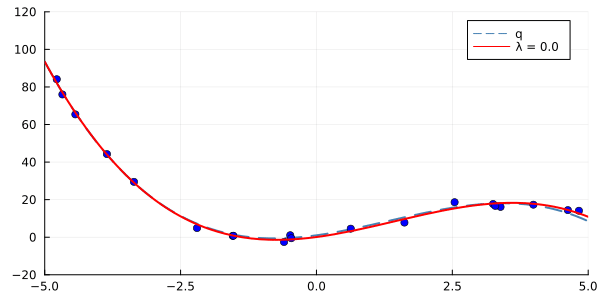

In [108]:
anim = @animate for λ in 0:10
    plot(q, label = "q", size = (600,300), linestyle = :dash, lw = 2,
        color = :steelblue, 
        xlims = (-5,5),
        ylims = (-20, 120))
    scatter!(X,Y, label=false, color = :blue)
    print(λ, Q(λ))
    plot!(Q(λ/n), label = "λ = $(λ/n)", color = :red, lw = 2)
end
gif(anim, "ridge_regression.gif", fps = 2)